# Introduction

Building on `20240219_simple2`, add `前走距離差` to see if this improves the model.

In [12]:
import re
import tempfile
import warnings

import japanize_matplotlib
import lightgbm as lgb
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import mlflow
import numpy as np
import pandas as pd
import seaborn as sns
from gymnasium import Env, spaces
from hyperopt import STATUS_OK, SparkTrials, Trials, fmin, hp, tpe
from hyperopt.pyll.base import scope
from mlflow.models.signature import ModelSignature
from mlflow.types.schema import ColSpec, Schema
from pyspark.sql import SparkSession
from pyspark.sql import functions as f
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score,
    auc,
    confusion_matrix,
    f1_score,
    log_loss,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from stable_baselines3 import PPO

from JapanHorseRaceAnalytics.utilities.base import get_base_dir, read_hive_table
from JapanHorseRaceAnalytics.utilities.metrics import (
    calculate_binary_classifier_statistics,
)
from JapanHorseRaceAnalytics.utilities.mlflow import get_colspecs
from JapanHorseRaceAnalytics.utilities.structured_logger import logger

pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 1000)

# Data Collection

In [2]:
# warehouse_dir = f"{get_base_dir()}/spark-warehouse"
# postgres_driver_path = f"{get_base_dir()}/jars/postgresql-42.7.1.jar"

# spark = (
#     SparkSession.builder.appName("20240211_competitors")
#     .config("spark.driver.memory", "21g")
#     .config("spark.sql.warehouse.dir", warehouse_dir)
#     .config("spark.jars", postgres_driver_path)
#     .config("spark.executor.extraClassPath", postgres_driver_path)
#     .config("spark.driver.extraClassPath", postgres_driver_path)
#     .enableHiveSupport()
#     .getOrCreate()
# )

In [3]:
data = read_hive_table(
    table_name="features_20240217_v1",
    schema="jhra_curated",
    spark_session=None,
    # use_cache=False,
)

# drop from data where cat_トラック種別 == "障害"
data = data[(data["cat_トラック種別"] != "障害")]

# This would mess up the number of horses in the race
# drop from data where meta_int_race_horses_異常区分 != '0'
# data = data[(data["meta_int_race_horses_異常区分"] == "0")]

data = data.reset_index(drop=True)

data.head()

{"event": "Read from parquet /Users/hankehly/Projects/JapanHorseRaceAnalytics/data/sql_tables/features_20240217_v1.snappy.parquet to pandas", "level": "info", "timestamp": "2024-02-21T22:24:53.192984Z", "logger": "JapanHorseRaceAnalytics.utilities.base"}


,meta_レースキー,meta_馬番,meta_着順,meta_本賞金,meta_単勝的中,meta_単勝払戻金,meta_複勝的中,meta_複勝払戻金,meta_int_races_レースキー,meta_発走日時,meta_場コード,cat_四半期,cat_距離,cat_事前_馬場状態コード,cat_事前_レース条件_トラック情報_右左,cat_事前_レース条件_トラック情報_内外,cat_事前_レース条件_種別,cat_事前_レース条件_条件,cat_事前_レース条件_記号,cat_事前_レース条件_重量,cat_事前_レース条件_グレード,num_事前_馬場差,cat_実績_馬場状態コード,cat_実績_レース条件_トラック情報_右左,cat_実績_レース条件_トラック情報_内外,cat_実績_レース条件_種別,cat_実績_レース条件_条件,cat_実績_レース条件_記号,cat_実績_レース条件_重量,cat_実績_レース条件_グレード,num_実績_馬場差,num_頭数,cat_トラック種別,cat_馬場状態内,cat_馬場状態中,cat_馬場状態外,num_直線馬場差最内,num_直線馬場差内,num_直線馬場差中,num_直線馬場差外,num_直線馬場差大外,cat_芝種類,cat_草丈,cat_転圧,cat_凍結防止剤,num_中間降水量,meta_int_race_horses_レースキー,meta_int_race_horses_馬番,meta_int_race_horses_血統登録番号,meta_int_race_horses_発走日時,meta_int_race_horses_異常区分,num_事前_ＩＤＭ,cat_事前_脚質,num_事前_単勝オッズ,num_事前_複勝オッズ,cat_事前_馬体,cat_事前_気配コード,cat_事前_上昇度,cat_事前_クラスコード,num_事前_テン指数,num_事前_ペース指数,num_事前_上がり指数,num_実績_ＩＤＭ,cat_実績_脚質,num_実績_単勝オッズ,num_実績_複勝オッズ,cat_実績_馬体,cat_実績_気配コード,cat_実績_上昇度,cat_実績_クラスコード,num_実績_テン指数,num_実績_ペース指数,num_実績_上がり指数,num_負担重量,num_馬体重,num_馬体重増減,cat_性別,cat_トラック種別瞬発戦好走馬,cat_トラック種別消耗戦好走馬,num_一走前不利,num_二走前不利,num_三走前不利,num_一走前着順,num_二走前着順,num_三走前着順,num_四走前着順,num_五走前着順,num_六走前着順,num_騎手指数,num_情報指数,num_オッズ指数,num_パドック指数,num_総合指数,cat_馬具変更情報,cat_脚元情報,cat_見習い区分,cat_オッズ印,cat_パドック印,cat_直前総合印,cat_距離適性,num_ローテーション,num_基準オッズ,num_基準人気順位,num_基準複勝オッズ,num_基準複勝人気順位,num_特定情報◎,num_特定情報○,num_特定情報▲,num_特定情報△,num_特定情報×,num_総合情報◎,num_総合情報○,num_総合情報▲,num_総合情報△,num_総合情報×,num_人気指数,num_調教指数,num_厩舎指数,cat_調教矢印コード,cat_厩舎評価コード,num_騎手期待連対率,num_激走指数,cat_蹄コード,cat_重適性コード,cat_ブリンカー,cat_印コード_総合印,cat_印コード_ＩＤＭ印,cat_印コード_情報印,cat_印コード_騎手印,cat_印コード_厩舎印,cat_印コード_調教印,cat_印コード_激走印,num_展開予想データ_位置指数,cat_展開予想データ_ペース予想,num_展開予想データ_道中順位,num_展開予想データ_道中差,cat_展開予想データ_道中内外,num_展開予想データ_後３Ｆ順位,num_展開予想データ_後３Ｆ差,cat_展開予想データ_後３Ｆ内外,num_展開予想データ_ゴール順位,num_展開予想データ_ゴール差,cat_展開予想データ_ゴール内外,cat_展開予想データ_展開記号,num_激走順位,num_LS指数順位,num_テン指数順位,num_ペース指数順位,num_上がり指数順位,num_位置指数順位,num_騎手期待単勝率,num_騎手期待３着内率,cat_輸送区分,num_展開参考データ_馬スタート指数,num_展開参考データ_馬出遅率,num_万券指数,cat_万券印,cat_激走タイプ,cat_休養理由分類コード,cat_芝ダ障害フラグ,cat_距離フラグ,cat_クラスフラグ,cat_転厩フラグ,cat_去勢フラグ,cat_乗替フラグ,cat_放牧先ランク,cat_厩舎ランク,cat_前走トップ3,cat_枠番,cat_前走枠番,num_入厩何日前,cat_入厩15日未満,cat_入厩35日以上,num_前走距離差,num_年齢,cat_4歳以下,num_4歳以下頭数,num_4歳以下割合,num_レース数,num_1位完走,num_トップ3完走,num_1位完走率,num_トップ3完走率,num_過去5走勝率,num_過去5走トップ3完走率,num_場所レース数,num_場所1位完走,num_場所トップ3完走,num_場所1位完走率,num_場所トップ3完走率,num_トラック種別レース数,num_トラック種別1位完走,num_トラック種別トップ3完走,num_トラック種別1位完走率,num_トラック種別トップ3完走率,num_馬場状態レース数,num_馬場状態1位完走,num_馬場状態トップ3完走,num_馬場状態1位完走率,num_馬場状態トップ3完走率,num_距離レース数,num_距離1位完走,num_距離トップ3完走,num_距離1位完走率,num_距離トップ3完走率,num_四半期レース数,num_四半期1位完走,num_四半期トップ3完走,num_四半期1位完走率,num_四半期トップ3完走率,num_過去3走順位平方和,num_本賞金累計,num_1位完走平均賞金,num_レース数平均賞金,num_連続1着,num_連続3着内,num_事前_競争相手最高ＩＤＭ,num_事前_競争相手最低ＩＤＭ,num_事前_競争相手平均ＩＤＭ,num_事前_競争相手ＩＤＭ標準偏差,num_事前_競争相手最高単勝オッズ,num_事前_競争相手最低単勝オッズ,num_事前_競争相手平均単勝オッズ,num_事前_競争相手単勝オッズ標準偏差,num_事前_競争相手最高複勝オッズ,num_事前_競争相手最低複勝オッズ,num_事前_競争相手平均複勝オッズ,num_事前_競争相手複勝オッズ標準偏差,num_事前_競争相手最高テン指数,num_事前_競争相手最低テン指数,num_事前_競争相手平均テン指数,num_事前_競争相手テン指数標準偏差,num_事前_競争相手最高ペース指数,num_事前_競争相手最低ペース指数,num_事前_競争相手平均ペース指数,num_事前_競争相手ペース指数標準偏差,num_事前_競争相手最高上がり指数,num_事前_競争相手最低上がり指数,num_事前_競争相手平均上がり指数,num_事前_競争相手上がり指数標準偏差,num_実績_競争相手最高ＩＤＭ,num_実績_競争相手最低ＩＤＭ,num_実績_競争相手平均ＩＤＭ,num_実績_競争相手ＩＤＭ標準偏差,num_実績_競争相手最高単勝オッズ,num_実績_競争相手最低単勝オッズ,num_実績_競争相手平均単勝オッズ,num_実績_競争相手単勝オッズ標準偏差,num_実績_競争相手最高複勝オッズ,num_実績_競争相手最低複勝オッズ,num_実績_競争相手平均複勝オッズ,num_実績_競争相手複勝オッズ標準偏差,num_実績_競争相手最高テン指数,num_実績_競争相手最低テン指数,num_実績_競争相手平均テン指数,num_実績_競争相手テン指数標準偏差,num_実績_競争相手最高ペース指数,num_実績_競争相手最低ペース指数,num_実績_競争相手平均ペース指数,num_実績_競争相手ペース指数標準偏差,num_実績_競争相手最高上がり指数,num_実績_競争相手最低上がり指数,num_実績_競争相手平均上がり指数,num_実績_競争相手上がり指数標準偏差,num_競争相手最高負担重量,num_競争相手最低負担重量,num_競争相手平均負担重量,num_競争相手負担重量標準偏差,num_競争相手最高馬体重,num_競争相手最低馬体重,num_競争相手平均馬体重,num_競争相手馬体重標準偏差,num_競争相手最高馬体重増減,num_競争相手最低馬体重増減,num_競争相手平均馬体重増減,num_競争相手馬体重増減標準偏差,num_競争相手性別牡割合,num_競争相手性別牝割合,num_競争相手性別セ割合,num_競争相手最高一走前不利,num_競争相手最低一走前不利,num_競争相手平均一走前不利,num_競争相手一走前不利標準偏差,num_競争相手最高二走前不利,num_競争相手最低二走前不利,num_競争相手平均二走前不利,num_競争相手二走前不利標準偏差,num_競争相手最高三走前不利,num_競争相手最低三走前不利,num_競争相手平均三走前不利,n

# Model Training

## Feature selection

In [6]:
data_ = pd.DataFrame(index=data.index)


# Meta columns
data_["レースキー"] = data["meta_レースキー"]
data_["発走日時"] = data["meta_発走日時"]
data_["馬番"] = data["meta_馬番"]
data_["着順"] = data["meta_着順"]
data_["複勝的中"] = data["meta_複勝的中"]
data_["複勝払戻金"] = data["meta_複勝払戻金"]
data_["血統登録番号"] = data["meta_int_race_horses_血統登録番号"]

# Features
data_["距離"] = data["cat_距離"]
data_["前走距離差"] = data["num_前走距離差"]
data_["年齢"] = data["num_年齢"]
data_["馬体重"] = data["num_馬体重"]
data_["馬体重増減"] = data["num_馬体重増減"]
data_["負担重量"] = data["num_負担重量"]
data_["頭数"] = data["num_頭数"]
data_["トラック種別"] = data["cat_トラック種別"]
data_["一走前着順"] = data["num_一走前着順"]
data_["二走前着順"] = data["num_二走前着順"]
data_["三走前着順"] = data["num_三走前着順"]
data_["四走前着順"] = data["num_四走前着順"]
data_["五走前着順"] = data["num_五走前着順"]
data_["複勝オッズ"] = data["num_事前_複勝オッズ"]


# fmt: off
categories = np.array([
    # ["距離", [1000, 1150, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 3000, 3200, 3400, 3600]]
])
category_keys = categories[:, 0] if categories else []
category_values = categories[:, 1] if categories else []
num_cols = [
    "前走距離差",
    "年齢",
    "馬体重増減",
    "負担重量",
    "頭数",
    "一走前着順",
    "二走前着順",
    "三走前着順",
    "四走前着順",
    "五走前着順",
    "複勝オッズ",
]
num_null_cols = [
    "馬体重"  # 95% of 馬体重 null values are where 異常区分 != 0
]
cat_cols = [
    # "トラック種別"
]
meta_cols = ["レースキー", "複勝的中", "複勝払戻金"]
all_cols = category_keys + num_cols + num_null_cols + cat_cols + meta_cols
# fmt: on

preprocessor = ColumnTransformer(
    transformers=[
        # fmt: off
        ("ord", OrdinalEncoder(categories=category_values), category_keys),
        ("num", StandardScaler(), num_cols),
        ("num_null", Pipeline(steps=[("imputer", SimpleImputer()), ("scaler", StandardScaler())]), num_null_cols),
        ("cat", OneHotEncoder(drop="if_binary"), cat_cols),
        ("meta", "passthrough", meta_cols)
        # fmt: on
    ],
    remainder="drop",
)

/var/folders/1p/ngsbv_gj3px52qmhqchv10j00000gn/T/ipykernel_8080/2306883145.py:34: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  category_keys = categories[:, 0] if categories else []
/var/folders/1p/ngsbv_gj3px52qmhqchv10j00000gn/T/ipykernel_8080/2306883145.py:35: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  category_values = categories[:, 1] if categories else []


## Check feature correlation

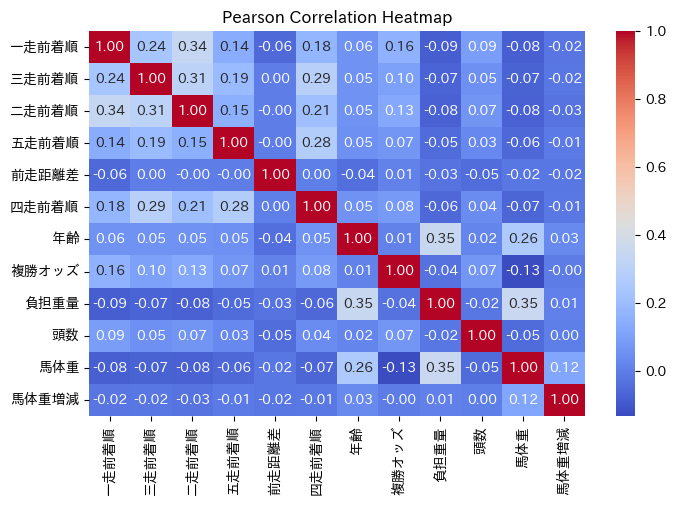

In [20]:
corr = data_[sorted(num_cols + num_null_cols)].corr()
plt.figure(figsize=(8, 5))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Pearson Correlation Heatmap")
plt.show()

## Train/test split

In [10]:
X = data_
y = data_["複勝的中"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# X_train_prep = preprocessor.fit_transform(X_train)
# X_test_prep = preprocessor.transform(X_test)

print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")
# print(f"X_train_prep: {X_train_prep.shape}")
# print(f"X_test_prep: {X_test_prep.shape}")

X_train: (857061, 20)
X_test: (214266, 20)
y_train: (857061,)
y_test: (214266,)


## Define Objective Function

In [11]:
def create_objective_fn(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    X_test: pd.DataFrame,
    y_test: pd.Series,
    df_payout: pd.DataFrame,
    experiment_name: str,
):
    """
    df_payout should have the same index as *_test and have the following columns:
    * レースキー
    * 馬番
    * 距離
    * 発走日時
    * 年齢
    # * グレード
    # * 場コード
    * payout - amount won if betting 100 yen.
    """

    def train(params):
        def profit_loss(row, payout_column_name, bet_amount=100):
            if row["pred"] and row["actual"]:
                payout = row[payout_column_name] * (bet_amount / 100)
                return payout - bet_amount
            elif row["pred"] and not row["actual"]:
                return -bet_amount
            else:
                return 0

        mlflow.set_experiment(experiment_name=experiment_name)
        with mlflow.start_run():
            mlflow.log_params(params)

            categories = {
                "距離": [1000, 1150, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 3000, 3200, 3400, 3600]
            }

            preprocessor = ColumnTransformer(
                transformers=[
                    # fmt: off
                    ("ordinal", OrdinalEncoder(categories=[categories["距離"]]), ["距離"]),
                    ("numeric_scale", StandardScaler(), ["前走距離差", "年齢", "馬体重増減", "負担重量", "頭数", "一走前着順", "二走前着順", "三走前着順", "四走前着順", "五走前着順"]),
                    ("numeric_impute_scale", Pipeline(steps=[("imputer", SimpleImputer()), ("scaler", StandardScaler())]), [
                        "馬体重"  # 95% of 馬体重 null values are where 異常区分 != 0
                    ]),
                    ("onehot", OneHotEncoder(drop="if_binary"), ["トラック種別"]),
                    # fmt: on
                ],
                remainder="drop",
            )
            model = Pipeline(
                steps=[
                    ("preprocessor", preprocessor),
                    ("classifier", lgb.LGBMClassifier(**params)),
                ]
            )

            # RestException: INVALID_PARAMETER_VALUE: Dataset schema exceeds the maximum length of 65535
            # Xy_train = pd.concat((X_train, y_train), axis=1)
            # dataset = mlflow.data.from_pandas(Xy_train, targets=y_train.name)
            # mlflow.log_input(dataset, context="train")

            input_schema = Schema(get_colspecs(X_train))
            output_schema = Schema([ColSpec("double", y_train.name)])
            signature = ModelSignature(inputs=input_schema, outputs=output_schema)
            input_example = X_train.iloc[:25]
            model.fit(X_train, y_train)
            mlflow.sklearn.log_model(
                sk_model=model,
                signature=signature,
                input_example=input_example,
                artifact_path="model",
            )

            y_pred_proba = model.predict_proba(X_test)[:, 1]
            y_pred = model.predict(X_test)

            metrics = {
                "loss": log_loss(y_test, y_pred_proba),
                "accuracy": accuracy_score(y_test, y_pred),
                "precision": precision_score(y_test, y_pred),
                "recall": recall_score(y_test, y_pred),
                "f1": f1_score(y_test, y_pred),
                "roc_auc": roc_auc_score(y_test, y_pred),
            }
            mlflow.log_metrics(metrics)

            # Calculate payout rates by group
            results = pd.concat(
                [
                    df_payout,
                    pd.DataFrame(
                        np.c_[y_test, y_pred, y_pred_proba],
                        columns=["actual", "pred", "pred_proba_true"],
                    ),
                ],
                axis=1,
            )
            payout_all = calculate_binary_classifier_statistics(
                results, group_by=None, payout_column_name="payout"
            )
            payout_month = calculate_binary_classifier_statistics(
                results,
                group_by=results["発走日時"].dt.month,
                payout_column_name="payout",
            )
            payout_distance = calculate_binary_classifier_statistics(
                results,
                group_by=pd.cut(x=results["距離"], bins=[0, 1400, 1800, 10000]),
                payout_column_name="payout",
            )
            payout_season = calculate_binary_classifier_statistics(
                results,
                group_by=results["発走日時"].dt.month % 12 // 3,
                payout_column_name="payout",
            )
            payout_year = calculate_binary_classifier_statistics(
                results,
                group_by=results["発走日時"].dt.year,
                payout_column_name="payout",
            )
            payout_age = calculate_binary_classifier_statistics(
                results,
                group_by=pd.cut(results["年齢"], bins=[0, 3, 6, 100]),
                payout_column_name="payout",
            )
            # payout_grade = calculate_binary_classifier_statistics(
            #     results,
            #     group_by=results["グレード"],
            #     payout_column_name="payout",
            # )
            # payout_racetrack = calculate_binary_classifier_statistics(
            #     results, group_by=results["場コード"], payout_column_name="payout"
            # )
            payout = (
                pd.concat(
                    [
                        pd.DataFrame(payout_all).T.assign(group="all"),
                        pd.DataFrame(payout_month).T.assign(group="month"),
                        pd.DataFrame(payout_distance).T.assign(group="distance"),
                        pd.DataFrame(payout_season).T.assign(group="season"),
                        pd.DataFrame(payout_year).T.assign(group="year"),
                        pd.DataFrame(payout_age).T.assign(group="horse_age"),
                        # pd.DataFrame(payout_grade).T.assign(group="grade"),
                        # pd.DataFrame(payout_racetrack).T.assign(group="racetrack"),
                    ],
                    axis=0,
                )
                .rename_axis(index="part")
                .reset_index()
            )
            # Move "group" and "part" columns to the first position in this dataframe
            payout = payout[
                ["group", "part"]
                + [c for c in payout.columns if c not in ["group", "part"]]
            ]

            # Save payout rates as csv
            with tempfile.NamedTemporaryFile(prefix="payout_rate_", suffix=".csv") as f:
                payout.to_csv(f.name, index=False)
                mlflow.log_artifact(f.name)

            # Log payout rates as metrics
            payout_metrics = {}
            for group_name, group in payout.groupby("group"):
                for i, row in group.iterrows():
                    key = re.sub(r"\W", "_", f"payout_rate_{group_name}_{row['part']}")
                    payout_metrics[key] = row["payout_rate"]
            mlflow.log_metrics(payout_metrics)

            # Suppress UserWarning messages from matplotlib
            warnings.filterwarnings("ignore", category=UserWarning)

            # Plot payout rates by group
            sns.set_theme(style="whitegrid")
            fig, axes = plt.subplots(2, 4, figsize=(20, 10))
            for (group, df), ax in zip(payout.groupby("group"), axes.flatten()):
                sns.barplot(x="part", y="payout_rate", data=df, ax=ax)
                ax.set_title(group)
                ax.set_ylim(0, 150)
                ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
                ax.set_ylabel("payout rate")
                ax.set_xlabel("")
                ax.yaxis.set_major_formatter(ticker.PercentFormatter())
            with tempfile.NamedTemporaryFile(prefix="payout_rate_", suffix=".png") as f:
                plt.tight_layout()
                plt.savefig(f.name)
                plt.close()
                mlflow.log_artifact(f.name)

            # Plot bank balance over time
            results["profit_loss"] = results.apply(
                profit_loss, args=("payout", 100), axis=1
            )
            daily_profit_loss = results.groupby("発走日時")["profit_loss"].sum()
            bank_balance = daily_profit_loss.cumsum()
            plt.figure(figsize=(10, 10))
            ax = plt.subplot(1, 1, 1)
            ax.plot(bank_balance.index, bank_balance.values)
            ax.set_title("Bank Balance")
            ax.set_xlabel("Date")
            ax.set_ylabel("Bank Balance")
            ax.grid(True)
            ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
            with tempfile.NamedTemporaryFile(
                prefix="bank_balance_", suffix=".png"
            ) as f:
                plt.tight_layout()
                plt.savefig(f.name)
                plt.close()
                mlflow.log_artifact(f.name)

            # Confusion Matrix
            conf_matrix = confusion_matrix(y_test, y_pred)
            _, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
            sns.heatmap(conf_matrix, annot=True, fmt="g", cmap="Blues", ax=ax1)
            ax1.set_xlabel("Predicted")
            ax1.set_ylabel("Actual")
            ax1.set_title("Confusion Matrix")
            sns.heatmap(
                conf_matrix / conf_matrix.sum(axis=1)[:, None],
                annot=True,
                fmt=".2%",
                cmap="Blues",
                ax=ax2,
            )
            ax2.set_xlabel("Predicted")
            ax2.set_ylabel("Actual")
            ax2.set_title("Normalized Confusion Matrix")
            with tempfile.NamedTemporaryFile(prefix="confusion_matrix_", suffix=".png") as f:
                plt.tight_layout()
                plt.savefig(f.name)
                plt.close()
                mlflow.log_artifact(f.name)

            # ROC Curve
            fpr, tpr, _ = roc_curve(y_test, y_pred)
            roc_auc = auc(fpr, tpr)
            _, ax = plt.subplots(figsize=(10, 10))
            ax.plot(fpr, tpr, color="darkorange", lw=2, label="ROC curve (area = %0.2f)" % roc_auc)
            ax.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
            ax.set_xlim([0.0, 1.0])
            ax.set_ylim([0.0, 1.0])
            ax.set_xlabel("False Positive Rate")
            ax.set_ylabel("True Positive Rate")
            ax.set_title("Receiver Operating Characteristic")
            ax.legend(loc="lower right")
            with tempfile.NamedTemporaryFile(prefix="roc_curve_", suffix=".png") as f:
                plt.tight_layout()
                plt.savefig(f.name)
                plt.close()
                mlflow.log_artifact(f.name)

            # Feature Importances
            feature_importances = zip(
                model.named_steps["preprocessor"].get_feature_names_out(),
                model.named_steps["classifier"].feature_importances_,
            )
            feature_importances_df = (
                pd.DataFrame(
                    data=feature_importances, columns=["feature", "importance"]
                )
                .sort_values("importance", ascending=False)
                .reset_index(drop=True)
            )
            with tempfile.NamedTemporaryFile(
                prefix="feature_importance_", suffix=".csv"
            ) as f:
                feature_importances_df.to_csv(f.name, index=False)
                mlflow.log_artifact(f.name)

            sns.set_theme(style="whitegrid")
            plt.figure(figsize=(10, 12))
            ax = sns.barplot(x="importance", y="feature", data=feature_importances_df.iloc[:50])
            ax.set_title("Feature Importances (Top 50)")
            ax.set_xlabel("Importance")
            ax.set_ylabel("Features")
            with tempfile.NamedTemporaryFile(prefix="feature_importance_", suffix=".png") as f:
                plt.tight_layout()
                plt.savefig(f.name)
                plt.close()
                mlflow.log_artifact(f.name)

            return {"status": STATUS_OK, "params": params, "model": model, **metrics}

    return train

## Hyperparameter Optimization

In [12]:
space = {
    "boosting_type": hp.choice("boosting_type", ["gbdt", "dart", "goss"]),
    "learning_rate": hp.loguniform("learning_rate", -5, 0),  # between e^-5 and 1
    "n_estimators": scope.int(hp.quniform("n_estimators", 100, 1000, 1)),
    "max_depth": scope.int(hp.quniform("max_depth", 3, 10, 1)),
    "num_leaves": scope.int(hp.quniform("num_leaves", 20, 150, 1)),
    "min_child_samples": scope.int(hp.quniform("min_child_samples", 20, 500, 1)),
    "feature_fraction": hp.uniform("feature_fraction", 0.5, 1.0),
    "lambda_l1": hp.uniform("lambda_l1", 0, 5),
    "lambda_l2": hp.uniform("lambda_l2", 0, 5),
    "min_split_gain": hp.uniform("min_split_gain", 0, 1),
    "min_child_weight": hp.uniform("min_child_weight", 0.001, 10),
    "subsample": hp.uniform("subsample", 0.5, 1),
    "colsample_bytree": hp.uniform("colsample_bytree", 0.5, 1),
    "reg_alpha": hp.uniform("reg_alpha", 0.0, 1.0),
    "reg_lambda": hp.uniform("reg_lambda", 0.0, 1.0),
    "objective": "binary",
    "class_weight": "balanced",
    "verbose": -1,
    "seed": 42,
}

In [13]:
df_payout_cols = [
    "レースキー",
    "距離",
    "発走日時",
    "馬番",
    "着順",
    "複勝的中",
    "複勝払戻金",
    "血統登録番号",
    "年齢",
]

df_payout = (
    data_.iloc[X_test.index][df_payout_cols]
    .reset_index(drop=True)
    .rename(columns={"複勝払戻金": "payout"})
)

experiment_name = "20240219_simple3"
if mlflow.get_experiment_by_name(experiment_name) is None:
    mlflow.create_experiment(experiment_name)

fn = create_objective_fn(
    X_train[feat_cols],
    y_train,
    X_test[feat_cols],
    y_test,
    df_payout=df_payout,
    experiment_name=experiment_name,
)

In [14]:
trials = SparkTrials(parallelism=3, spark_session=spark)
# trials = Trials()
fmin(fn=fn, space=space, algo=tpe.suggest, max_evals=60, trials=trials)

  0%|          | 0/60 [00:00<?, ?trial/s, best loss=?]

build_posterior_wrapper took 0.002722 seconds
TPE using 0 trials
build_posterior_wrapper took 0.005978 seconds
TPE using 1/1 trials with best loss inf
build_posterior_wrapper took 0.001771 seconds
TPE using 2/2 trials with best loss inf
build_posterior_wrapper took 0.001830 secondse 1:>                  (0 + 1) / 1]
TPE using 3/3 trials with best loss inf
Closing down clientserver connection                                            


  2%|▏         | 1/60 [00:22<21:45, 22.13s/trial, best loss: 0.591735201569792]

build_posterior_wrapper took 0.002008 seconds
TPE using 4/4 trials with best loss 0.591735
Closing down clientserver connection                                            


  3%|▎         | 2/60 [00:25<10:31, 10.89s/trial, best loss: 0.591735201569792]

build_posterior_wrapper took 0.001806 seconds
TPE using 5/5 trials with best loss 0.591735
Closing down clientserver connection                                            


  5%|▌         | 3/60 [01:09<24:47, 26.09s/trial, best loss: 0.5886535125054845]

build_posterior_wrapper took 0.001929 seconds
TPE using 6/6 trials with best loss 0.588654
Closing down clientserver connection                                            


  7%|▋         | 4/60 [01:12<15:51, 16.98s/trial, best loss: 0.5886535125054845]

build_posterior_wrapper took 0.002824 secondse 5:>                  (0 + 1) / 1]
TPE using 7/7 trials with best loss 0.588654
Closing down clientserver connection                                            


  8%|▊         | 5/60 [01:31<16:15, 17.74s/trial, best loss: 0.5886535125054845]

build_posterior_wrapper took 0.003928 secondse 5:>                  (0 + 1) / 1]
TPE using 8/8 trials with best loss 0.588654
Closing down clientserver connection                                            


 10%|█         | 6/60 [04:14<1:00:19, 67.02s/trial, best loss: 0.5886535125054845]

build_posterior_wrapper took 0.002303 seconds
TPE using 9/9 trials with best loss 0.588654
Closing down clientserver connection                                            


 12%|█▏        | 7/60 [04:37<46:31, 52.66s/trial, best loss: 0.5886535125054845]  

build_posterior_wrapper took 0.002044 seconds
TPE using 10/10 trials with best loss 0.588654
Closing down clientserver connection                                            


 13%|█▎        | 8/60 [05:14<41:21, 47.73s/trial, best loss: 0.5886535125054845]

build_posterior_wrapper took 0.002417 seconds
TPE using 11/11 trials with best loss 0.588654
Closing down clientserver connection                                            


 15%|█▌        | 9/60 [05:24<30:33, 35.95s/trial, best loss: 0.5886535125054845]

build_posterior_wrapper took 0.001812 secondse 10:>                 (0 + 1) / 1]
TPE using 12/12 trials with best loss 0.588654
Closing down clientserver connection                                            


 17%|█▋        | 10/60 [05:29<22:00, 26.40s/trial, best loss: 0.5886535125054845]

build_posterior_wrapper took 0.002182 seconds
TPE using 13/13 trials with best loss 0.588654
Closing down clientserver connection                                            


 18%|█▊        | 11/60 [05:47<19:28, 23.85s/trial, best loss: 0.5886535125054845]

build_posterior_wrapper took 0.001862 secondse 12:>                 (0 + 1) / 1]
TPE using 14/14 trials with best loss 0.588654
Closing down clientserver connection                                            


 20%|██        | 12/60 [05:52<14:30, 18.13s/trial, best loss: 0.5886535125054845]

build_posterior_wrapper took 0.002069 secondse 13:>                 (0 + 1) / 1]
TPE using 15/15 trials with best loss 0.588654
Closing down clientserver connection                                            


 22%|██▏       | 13/60 [06:08<13:42, 17.50s/trial, best loss: 0.5886535125054845]

build_posterior_wrapper took 0.002064 secondse 14:>                 (0 + 1) / 1]
TPE using 16/16 trials with best loss 0.588654
Closing down clientserver connection                                            


 23%|██▎       | 14/60 [06:33<15:10, 19.80s/trial, best loss: 0.5886535125054845]

build_posterior_wrapper took 0.001757 secondse 15:>                 (0 + 1) / 1]
TPE using 17/17 trials with best loss 0.588654
Closing down clientserver connection                                            


 25%|██▌       | 15/60 [06:50<14:14, 18.98s/trial, best loss: 0.5886535125054845]

build_posterior_wrapper took 0.001849 secondse 16:>                 (0 + 1) / 1]
TPE using 18/18 trials with best loss 0.588654
Closing down clientserver connection                                            


 27%|██▋       | 16/60 [06:53<10:23, 14.18s/trial, best loss: 0.5886535125054845]

build_posterior_wrapper took 0.001942 secondse 17:>                 (0 + 1) / 1]
TPE using 19/19 trials with best loss 0.588654
Closing down clientserver connection                                            


 28%|██▊       | 17/60 [07:38<16:37, 23.21s/trial, best loss: 0.5886535125054845]

build_posterior_wrapper took 0.001840 secondse 18:>                 (0 + 1) / 1]
TPE using 20/20 trials with best loss 0.588654
Closing down clientserver connection                                            


 30%|███       | 18/60 [07:49<13:41, 19.56s/trial, best loss: 0.5886535125054845]

build_posterior_wrapper took 0.004971 secondse 19:>                 (0 + 1) / 1]
TPE using 21/21 trials with best loss 0.588654
Closing down clientserver connection                                            


 32%|███▏      | 19/60 [08:17<15:07, 22.13s/trial, best loss: 0.5886535125054845]

build_posterior_wrapper took 0.001886 secondse 19:>                 (0 + 1) / 1]
TPE using 22/22 trials with best loss 0.588654
Closing down clientserver connection                                            


 33%|███▎      | 20/60 [08:20<10:55, 16.40s/trial, best loss: 0.5886535125054845]

build_posterior_wrapper took 0.001802 secondse 21:>                 (0 + 1) / 1]
TPE using 23/23 trials with best loss 0.588654
Closing down clientserver connection                                            


 35%|███▌      | 21/60 [08:52<13:44, 21.13s/trial, best loss: 0.5886535125054845]

build_posterior_wrapper took 0.001979 seconds
TPE using 24/24 trials with best loss 0.588654
Closing down clientserver connection                                            


 37%|███▋      | 22/60 [09:15<13:45, 21.73s/trial, best loss: 0.5886535125054845]

build_posterior_wrapper took 0.001811 secondse 22:>                 (0 + 1) / 1]
TPE using 25/25 trials with best loss 0.588654
Closing down clientserver connection                                            


 38%|███▊      | 23/60 [09:35<13:06, 21.24s/trial, best loss: 0.5886535125054845]

build_posterior_wrapper took 0.003979 secondse 24:>                 (0 + 1) / 1]
TPE using 26/26 trials with best loss 0.588654
Closing down clientserver connection                                            


 40%|████      | 24/60 [09:55<12:32, 20.91s/trial, best loss: 0.5886535125054845]

build_posterior_wrapper took 0.001848 secondse 25:>                 (0 + 1) / 1]
TPE using 27/27 trials with best loss 0.588654
Closing down clientserver connection                                            


 42%|████▏     | 25/60 [10:26<13:59, 23.98s/trial, best loss: 0.5886535125054845]

build_posterior_wrapper took 0.001970 seconds
TPE using 28/28 trials with best loss 0.588654
Closing down clientserver connection                                            


 43%|████▎     | 26/60 [10:46<12:45, 22.52s/trial, best loss: 0.5886535125054845]

build_posterior_wrapper took 0.001862 secondse 27:>                 (0 + 1) / 1]
TPE using 29/29 trials with best loss 0.588654
Closing down clientserver connection                                            


 45%|████▌     | 27/60 [10:58<10:39, 19.38s/trial, best loss: 0.5886535125054845]

Closing down clientserver connection                                            


 47%|████▋     | 28/60 [10:59<07:23, 13.87s/trial, best loss: 0.5881581726980979]

build_posterior_wrapper took 0.001848 seconds
TPE using 30/30 trials with best loss 0.588158
build_posterior_wrapper took 0.001843 secondse 29:>                 (0 + 1) / 1]
TPE using 31/31 trials with best loss 0.588158
Closing down clientserver connection                                            


 48%|████▊     | 29/60 [11:08<06:25, 12.43s/trial, best loss: 0.5881581726980979]

build_posterior_wrapper took 0.001850 seconds
TPE using 32/32 trials with best loss 0.588158
Closing down clientserver connection                                            


 50%|█████     | 30/60 [11:41<09:19, 18.65s/trial, best loss: 0.5881581726980979]

build_posterior_wrapper took 0.001896 secondse 31:>                 (0 + 1) / 1]
TPE using 33/33 trials with best loss 0.588158
Closing down clientserver connection                                            


 52%|█████▏    | 31/60 [12:14<11:07, 23.00s/trial, best loss: 0.5880659005185102]

build_posterior_wrapper took 0.001921 secondse 32:>                 (0 + 1) / 1]
TPE using 34/34 trials with best loss 0.588066
Closing down clientserver connection                                            
Closing down clientserver connection


 55%|█████▌    | 33/60 [12:31<07:20, 16.33s/trial, best loss: 0.5872720181692208]

build_posterior_wrapper took 0.001942 seconds                       (0 + 1) / 1]
TPE using 35/35 trials with best loss 0.587272
build_posterior_wrapper took 0.001970 secondse 34:>                 (0 + 1) / 1]
TPE using 36/36 trials with best loss 0.587272
Closing down clientserver connection                                            


 57%|█████▋    | 34/60 [12:58<08:14, 19.01s/trial, best loss: 0.5872720181692208]

build_posterior_wrapper took 0.001881 secondse 34:>                 (0 + 1) / 1]
TPE using 37/37 trials with best loss 0.587272
Closing down clientserver connection                                            


 58%|█████▊    | 35/60 [13:34<09:47, 23.50s/trial, best loss: 0.5872720181692208]

build_posterior_wrapper took 0.002225 secondse 36:>                 (0 + 1) / 1]
TPE using 38/38 trials with best loss 0.587272
Closing down clientserver connection                                            


 60%|██████    | 36/60 [13:45<07:56, 19.85s/trial, best loss: 0.5872720181692208]

build_posterior_wrapper took 0.002154 secondse 37:>                 (0 + 1) / 1]
TPE using 39/39 trials with best loss 0.587272
Closing down clientserver connection                                            


 62%|██████▏   | 37/60 [14:12<08:23, 21.89s/trial, best loss: 0.5872720181692208]

build_posterior_wrapper took 0.006250 secondse 38:>                 (0 + 1) / 1]
TPE using 40/40 trials with best loss 0.587272
Closing down clientserver connection                                            


 63%|██████▎   | 38/60 [14:25<07:06, 19.37s/trial, best loss: 0.5872720181692208]

build_posterior_wrapper took 0.002699 seconds
TPE using 41/41 trials with best loss 0.587272
Closing down clientserver connection                                            


 65%|██████▌   | 39/60 [14:51<07:27, 21.33s/trial, best loss: 0.5872720181692208]

build_posterior_wrapper took 0.002532 secondse 39:>                 (0 + 1) / 1]
TPE using 42/42 trials with best loss 0.587272
Closing down clientserver connection                                            


 67%|██████▋   | 40/60 [15:03<06:12, 18.62s/trial, best loss: 0.5872720181692208]

build_posterior_wrapper took 0.003001 secondse 41:>                 (0 + 1) / 1]
TPE using 43/43 trials with best loss 0.587272
Closing down clientserver connection                                            


 68%|██████▊   | 41/60 [15:35<07:09, 22.61s/trial, best loss: 0.5872720181692208]

build_posterior_wrapper took 0.001917 secondse 41:>                 (0 + 1) / 1]
TPE using 44/44 trials with best loss 0.587272
Closing down clientserver connection                                            


 70%|███████   | 42/60 [16:19<08:42, 29.01s/trial, best loss: 0.5872720181692208]

build_posterior_wrapper took 0.001978 secondse 41:>                 (0 + 1) / 1]
TPE using 45/45 trials with best loss 0.587272
Closing down clientserver connection                                            


 72%|███████▏  | 43/60 [22:48<38:31, 135.99s/trial, best loss: 0.5872720181692208]

build_posterior_wrapper took 0.001986 secondse 44:>                 (0 + 1) / 1]
TPE using 46/46 trials with best loss 0.587272
Closing down clientserver connection                                            


 73%|███████▎  | 44/60 [23:18<27:50, 104.43s/trial, best loss: 0.5872720181692208]

build_posterior_wrapper took 0.001769 seconds
TPE using 47/47 trials with best loss 0.587272
Closing down clientserver connection                                            


 75%|███████▌  | 45/60 [23:25<18:50, 75.36s/trial, best loss: 0.5872720181692208] 

build_posterior_wrapper took 0.002215 seconds
TPE using 48/48 trials with best loss 0.587272
Closing down clientserver connection                                            


 77%|███████▋  | 46/60 [23:53<14:17, 61.23s/trial, best loss: 0.5872720181692208]

build_posterior_wrapper took 0.002017 secondse 47:>                 (0 + 1) / 1]
TPE using 49/49 trials with best loss 0.587272
Closing down clientserver connection                                            


 78%|███████▊  | 47/60 [24:04<10:00, 46.21s/trial, best loss: 0.5872720181692208]

build_posterior_wrapper took 0.001882 seconds
TPE using 50/50 trials with best loss 0.587272
Closing down clientserver connection                                            


 80%|████████  | 48/60 [25:08<10:15, 51.33s/trial, best loss: 0.5872720181692208]

build_posterior_wrapper took 0.002205 seconds
TPE using 51/51 trials with best loss 0.587272
Closing down clientserver connection                                            


 82%|████████▏ | 49/60 [25:28<07:41, 41.98s/trial, best loss: 0.5872720181692208]

build_posterior_wrapper took 0.001875 seconds
TPE using 52/52 trials with best loss 0.587272
Closing down clientserver connection                                            


 83%|████████▎ | 50/60 [25:53<06:09, 36.92s/trial, best loss: 0.5872720181692208]

build_posterior_wrapper took 0.001934 seconds
TPE using 53/53 trials with best loss 0.587272
Closing down clientserver connection                                            


 85%|████████▌ | 51/60 [26:49<06:24, 42.72s/trial, best loss: 0.5872720181692208]

build_posterior_wrapper took 0.002142 secondse 50:>                 (0 + 1) / 1]
TPE using 54/54 trials with best loss 0.587272
Closing down clientserver connection                                            


 87%|████████▋ | 52/60 [27:43<06:09, 46.18s/trial, best loss: 0.5872720181692208]

build_posterior_wrapper took 0.005474 seconds
TPE using 55/55 trials with best loss 0.587272
Closing down clientserver connection                                            


 88%|████████▊ | 53/60 [28:18<04:58, 42.58s/trial, best loss: 0.5872720181692208]

build_posterior_wrapper took 0.004900 secondse 50:>                 (0 + 1) / 1]
TPE using 56/56 trials with best loss 0.587272
Closing down clientserver connection                                            


 90%|█████████ | 54/60 [33:26<12:13, 122.29s/trial, best loss: 0.5872720181692208]

build_posterior_wrapper took 0.001839 secondse 55:>                 (0 + 1) / 1]
TPE using 57/57 trials with best loss 0.587272
Closing down clientserver connection                                            


 92%|█████████▏| 55/60 [34:18<08:26, 101.28s/trial, best loss: 0.5872720181692208]

build_posterior_wrapper took 0.001902 secondse 55:>                 (0 + 1) / 1]
TPE using 58/58 trials with best loss 0.587272
Closing down clientserver connection                                            


 93%|█████████▎| 56/60 [34:48<05:19, 79.94s/trial, best loss: 0.5872720181692208] 

build_posterior_wrapper took 0.001815 secondse 55:>                 (0 + 1) / 1]
TPE using 59/59 trials with best loss 0.587272
Closing down clientserver connection                                            


 95%|█████████▌| 57/60 [35:12<03:09, 63.20s/trial, best loss: 0.5872720181692208]

Closing down clientserver connection                                            


 97%|█████████▋| 58/60 [35:24<01:35, 47.55s/trial, best loss: 0.5872720181692208]

Closing down clientserver connection                                            


 98%|█████████▊| 59/60 [35:34<00:36, 36.30s/trial, best loss: 0.5872720181692208]

Closing down clientserver connection                                            


100%|██████████| 60/60 [35:36<00:00, 35.60s/trial, best loss: 0.5872720181692208]

Queue empty, exiting run.


Closing down clientserver connection
Total Trials: 60: 60 succeeded, 0 failed, 0 cancelled.
Total Trials: 60: 60 succeeded, 0 failed, 0 cancelled.


{'boosting_type': 0,
 'colsample_bytree': 0.8016642153767848,
 'feature_fraction': 0.5578235667548754,
 'lambda_l1': 2.551673582227088,
 'lambda_l2': 1.3506414200964172,
 'learning_rate': 0.02904727910263315,
 'max_depth': 10.0,
 'min_child_samples': 68.0,
 'min_child_weight': 7.736782598405014,
 'min_split_gain': 0.0071078853628913415,
 'n_estimators': 861.0,
 'num_leaves': 121.0,
 'reg_alpha': 0.25409327833670503,
 'reg_lambda': 0.4275373164043184,
 'subsample': 0.9179630226670973}

# Conclusion